In [1]:
# import module

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import plotly.express as px
import collections.abc
collections.Iterable = collections.abc.Iterable
from astrodendro import Dendrogram
from astrodendro import structure
import pandas as pd

In [2]:
# load data

d2800 = np.load("datasets/2800.npz")
m2800 = d2800["arr_2"]

rv = d2800['arr_0']
pc = d2800['arr_1']

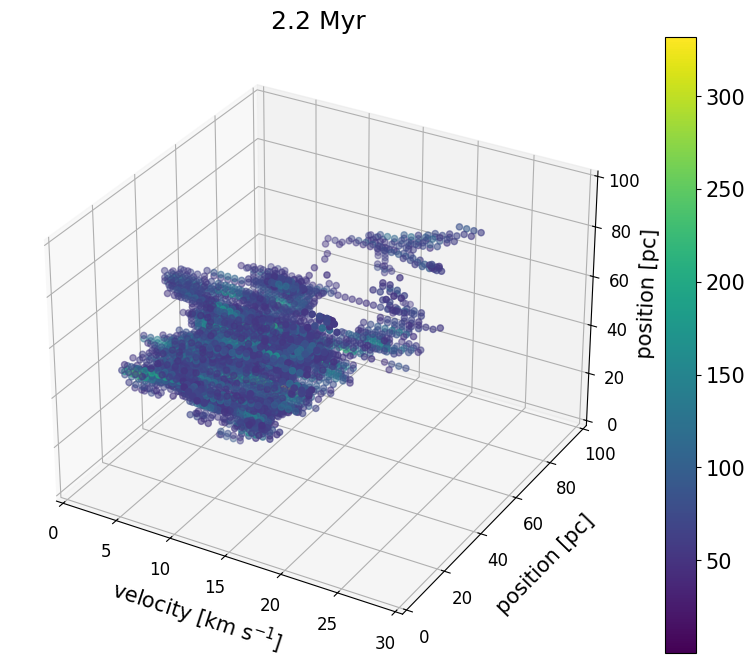

In [17]:
# make 3D map

shape = m2800.shape
gas_mass = m2800.reshape(-1)
colormap = plt.get_cmap('viridis')
norm = plt.Normalize(gas_mass.min(), gas_mass.max())

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

x_coords = np.repeat(np.arange(shape[0]), shape[1]*shape[2]) * rv
y_coords = np.tile(np.repeat(np.arange(shape[1]), shape[2]), shape[0]) * pc
z_coords = np.tile(np.arange(shape[2]), shape[0]*shape[1]) * pc

threshold = 50
mask= gas_mass > threshold

x_filtered = x_coords[mask]
y_filtered = y_coords[mask]
z_filtered = z_coords[mask]
gas_mass_filtered = gas_mass[mask]

scatter = ax.scatter(x_filtered, y_filtered, z_filtered, c=gas_mass_filtered, cmap=colormap, norm=norm)  

cbar = plt.colorbar(scatter, ax=ax, orientation='vertical')

ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title("2.2 Myr")

X = ax.set_xlabel('velocity [km s$^{-1}$]', labelpad=10)
Y = ax.set_ylabel('position [pc]', labelpad=10)
Z = ax.set_zlabel('position [pc]', labelpad=4)
plt.tick_params(labelsize=12)

plt.savefig("3Dmap_2800")

In [4]:
# compute dendrogram

dendro3D_2800 = Dendrogram.compute(m2800, min_value=90, min_delta=20, min_npix=50)

In [5]:
# make index

leaf_indices = [i for i, structure in enumerate(dendro3D_2800.all_structures) if structure.is_leaf]
branch_indices = [j for j, structure in enumerate(dendro3D_2800.all_structures) if structure.is_branch]

print(leaf_indices)
print(branch_indices)

[1, 4, 5, 6, 7]
[0, 2, 3]


In [6]:
# check the size of structures

leaf_npix, branch_npix = [], []

for structure_index in leaf_indices:
    structure = dendro3D_2800[structure_index]
    npix = structure.get_npix()
    leaf_npix.append(npix)
    
for structure_index in branch_indices:
    structure = dendro3D_2800[structure_index]
    npix = structure.get_npix()
    branch_npix.append(npix)

leaf_sizes = leaf_npix * rv * pc**2
branch_sizes = branch_npix * rv * pc**2

print(leaf_sizes)
print(branch_sizes)

[1154.62062925  523.12908769  393.59236121  246.61799848  156.93872631]
[ 173.13081712 1365.11780977   99.64363575]


In [7]:
# check the mass of structures

mass_per_leaf, mass_per_branch = [], []

for structure_index in leaf_indices:
    structure = dendro3D_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    leaf_mass = np.sum(m2800[indices])
    mass_per_leaf.append(leaf_mass)
    
for structure_index in branch_indices:
    structure = dendro3D_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    branch_mass = np.sum(m2800[indices])
    mass_per_branch.append(branch_mass)

total_mass_leaf = np.sum(mass_per_leaf)
total_mass_branch = np.sum(mass_per_branch)

print(mass_per_leaf)
print(total_mass_leaf)
print(mass_per_branch)
print(total_mass_branch)

[127110.21030058971, 63731.124389953664, 48490.12294342375, 30923.211329048863, 16890.754935891004]
287145.42389890697
[17608.39876997964, 147460.01732419487, 12639.701480433341]
177708.11757460784


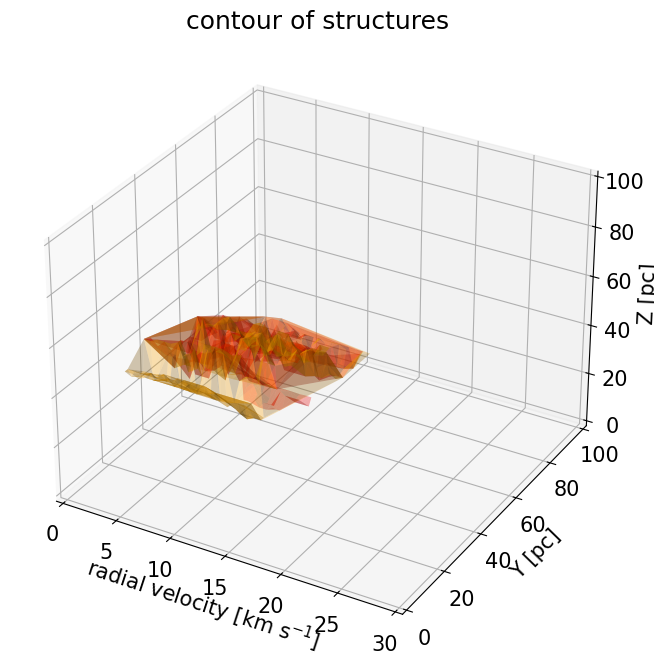

In [8]:
# plot the contour

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

for i, structure_index in enumerate(leaf_indices):
    structure = dendro3D_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * rv, indices[1] * pc, indices[2] * pc, color='red', alpha=0.3)
    
for j, structure_index in enumerate(branch_indices):
    structure = dendro3D_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    ax.plot_trisurf(indices[0] * rv, indices[1] * pc, indices[2] * pc, color='orange', alpha=0.3)

ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title("contour of structures")

X = ax.set_xlabel('radial velocity [km s$^{-1}$]')
Y = ax.set_ylabel('Y [pc]')
Z = ax.set_zlabel('Z [pc]')

#plt.savefig("dendro3D_2800_contour")

In [9]:
# make peaks list

x_peak, y_peak, v_peak, peak_value = [], [], [], []
for s in dendro3D_2800.leaves:
    x_ch, y_ch, v_ch = s.get_peak()[0]
    value = s.get_peak()[1]
    x_peak.append(round(float(x_ch), 6))
    y_peak.append(round(float(y_ch), 6))
    v_peak.append(round(float(v_ch), 6))
    peak_value.append(round(float(value), 6))
    
peak = pd.DataFrame({'v_peak':x_peak * rv, 'y_peak':y_peak * pc, 'z_peak':v_peak * pc, 'peak_value':peak_value})

print(peak)

   v_peak     y_peak     z_peak  peak_value
0    0.65  30.454102  30.454102  262.492184
1    5.20  44.296875  31.838379  246.365023
2    7.80  51.218262  45.681152  276.642427
3    9.75  58.139648  34.606934  273.570783
4   11.05  49.833984  23.532715  332.014636


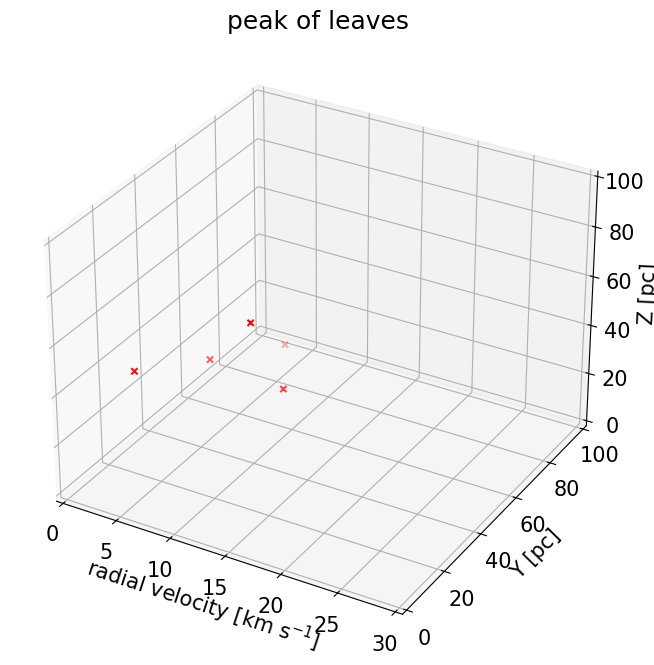

In [10]:
# plot the peaks

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(peak['v_peak'], peak['y_peak'], peak['z_peak'], marker='x', color='red')

ax.set_xlim3d(0, 30)
ax.set_ylim3d(0, 100)
ax.set_zlim3d(0, 100)

plt.title('peak of leaves')

X = ax.set_xlabel('radial velocity [km s$^{-1}$]')
Y = ax.set_ylabel('Y [pc]')
Z = ax.set_zlabel('Z [pc]')

#plt.savefig('dendro3D_2800_peak')

In [11]:
# plot by plotly

fig = px.scatter_3d(peak, x='v_peak', y='y_peak', z='z_peak')

# Leaf structures
for i, leaf_structure_index in enumerate(leaf_indices):
    leaf_structure = dendro3D_2800[leaf_structure_index]
    leaf_mask = leaf_structure.get_mask()
    leaf_mask_indices = np.where(leaf_mask)
    mesh_leaf = go.Mesh3d(x=leaf_mask_indices[0] * rv, 
                          y=leaf_mask_indices[1] * pc, 
                          z=leaf_mask_indices[2] * pc, 
                          opacity=0.3,
                          color='red',
                          name=f'Leaf {i + 1} - Surface')
    fig.add_trace(mesh_leaf)

# Branch structures
for j, branch_structure_index in enumerate(branch_indices):
    branch_structure = dendro3D_2800[branch_structure_index]
    branch_mask = branch_structure.get_mask()
    branch_mask_indices = np.where(branch_mask)
    mesh_branch = go.Mesh3d(x=branch_mask_indices[0] * rv, 
                            y=branch_mask_indices[1] * pc, 
                            z=branch_mask_indices[2] * pc,
                            opacity=0.3, 
                            color='orange',
                            name=f'Branch {j + 1} - Surface')
    fig.add_trace(mesh_branch)

fig.update_layout(
    scene=dict(
        xaxis=dict(title='radial velocity [km/s]', range=[0, 30]),
        yaxis=dict(title='Y [pc]', range=[0, 100]),
        zaxis=dict(title='Z [pc]', range=[0, 100]),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Structure Contours in 3D with Mesh Surface',
    margin=dict(l=0, r=0, b=0, t=40),
    showlegend=True)


In [12]:
# calculate radius

leaf_radius = np.cbrt(3 * (np.array(leaf_sizes)) / (4 * np.pi)) 
branch_radius = np.cbrt(3 * (np.array(branch_sizes)) / (4 * np.pi)) 

print(leaf_radius)
print(branch_radius)

[6.50804031 4.99850449 4.5462434  3.89026082 3.34616361]
[3.45749789 6.88166997 2.87598744]


In [13]:
# calculate velocity dispersion

delta_rv_leaf, delta_rv_branch = [], []

for structure_index in leaf_indices:
    structure = dendro3D_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    rv_indices = indices[0] * rv
    delta_rv = np.var(rv_indices)
    delta_rv_leaf.append(delta_rv)
    
for structure_index in branch_indices:
    structure = dendro3D_2800[structure_index]
    mask = structure.get_mask()
    indices = np.where(mask)
    rv_indices = indices[0] * rv
    delta_rv = np.var(rv_indices)
    delta_rv_branch.append(delta_rv)
    
print(delta_rv_leaf)
print(delta_rv_branch)

[7.654867379082986, 4.651128613945578, 4.456842728529082, 4.515546882971126, 2.097384101788863]
[8.821002277314838, 9.238067722624407, 3.6413558593750004]


In [14]:
# calculate virial parameter

alpha_vir_leaf = (1.2 * 10**3 * np.array(leaf_radius) * np.array(delta_rv_leaf)**2 / (3 * np.array(mass_per_leaf)))
alpha_vir_branch = (1.2 * 10**3 * np.array(branch_radius) * np.array(delta_rv_branch)**2 / (3 * np.array(mass_per_branch)))
                     
print(alpha_vir_leaf)
print(alpha_vir_branch)

[1.200066   0.67868022 0.7449275  1.02606491 0.34858929]
[6.11136071 1.59309559 1.20680307]
